# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [4]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [5]:
import itertools
from collections import Counter
from string import punctuation
from razdel import tokenize

## Датасет RIA. Предварительная обработка

Загрузим датасет ria. Одновременно сделаем преобразование даты из строки

In [6]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [7]:
data_ria = pd.read_csv('../data/ria.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"', error_bad_lines=False)

b'Skipping line 49866: expected 17 fields, saw 33\n'


In [8]:
# Проверим преобразование
data_ria.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors               float64
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                   int64
views                   int64
comm_count             object
dtype: object

In [9]:
data_ria.shape

(101543, 16)

In [10]:
# Так выглядет датасет ria
data_ria.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2019-08-10 06:35:00,https://ria.ru/20190810/1557366973.html,ria.ru,Происшествия,NaN,Восемнадцать туристов застряли на пляже в Прим...,"ВЛАДИВОСТОК, 10 авг – РИА Новости.nВосемнадцат...",-,-,-,-,-,-,0,70,-
1,2019-08-10 03:25:00,https://ria.ru/20190810/1557366343.html,ria.ru,В мире,NaN,Президент Парагвая даст показания по делу о сп...,"БУЭНОС-АЙРЕС, 10 авг – РИА Новости.nПрезидент ...",-,-,-,-,-,-,1,177,-
2,2019-08-10 03:26:00,https://ria.ru/20190810/1557366366.html,ria.ru,В мире,NaN,Андрейченко обвинили в угрозе теракта после но...,"МОСКВА, 10 авг - РИА Новости.nДмитрию Андрейче...",-,-,-,-,-,-,2,919,-
3,2019-08-10 03:31:00,https://ria.ru/20190810/1557366398.html,ria.ru,В мире,NaN,"Япония заявила, что не испугалась субботних пу...","МОСКВА, 10 авг - РИА Новости.nПравительство Яп...",-,-,-,-,-,-,1,140,-
4,2019-08-10 03:32:00,https://ria.ru/20190810/1557366421.html,ria.ru,Происшествия,NaN,"Власти Якутии погасят долг перед жителями, уча...","ЯКУТСК, 10 авг – РИА Новости.nСредства резервн...",-,-,-,-,-,-,3,1196,-


In [11]:
# Выясним в каким столбцах есть пустые данные
data_ria.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text            True
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

In [12]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_ria['text'].isnull().sum())
data_ria[data_ria['text'].isnull()].head()

Кол-во строк с значением NaN в столбце "Text" =  2


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
45983,2019-02-26 14:22:00,https://ria.ru/20190226/1551377894.html,ria.ru,Общество,NaN,Самый красивый трамвайный маршрут России,NaN,-,-,-,-,-,-,3,1140,-
97961,2019-07-29 16:15:00,https://ria.ru/20190729/1556918528.html,ria.ru,Безопасность,NaN,Крылья России. Самолёты ОКБ Сухого,NaN,-,-,-,-,-,-,43,1383,-


In [13]:
#Удалим эти строки
data_ria.drop(data_ria[data_ria.text.isnull()].index, inplace=True)

In [14]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_ria['text'].isnull().sum())

Кол-во строк с значением NaN в столбце "Text" =  0


Посмотрим сколько элементов Nan в столбце авторов

In [15]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_ria['authors'].isnull().sum())

Кол-во строк с значением NaN в столбце "authors" =  101541


Как видим все значения авторов Nan. Можно не использовать данные столбец

Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [19]:
def analysis_columns(columns):
    for column in columns:
        if column not in ['url', 'date', 'topics', 'authors', 'title', 'text']:
            yield(print(str(column) + ':', data_ria[column].unique()))

In [20]:
data_columns = list(analysis_columns(data_ria.columns))

edition: ['ria.ru']
reposts_fb: ['-']
reposts_vk: ['-']
reposts_ok: ['-']
reposts_twi: ['-']
reposts_lj: ['-']
reposts_tg: ['-']
likes: [    0     1     2     3    14    63    19     5    16   151     6    11
     4    29    13   184     8     7    10    30    28    18   108    95
   239    36    24   333   257    51    39     9    88    77    27    46
    12    70    23    22    34    67   100   421   256   381   318    33
    55   141    32   189    64    15   619    45    20   165    54   646
    82   160    81   250   216    17    50    31    47   161   366    75
   114    25   245   434    53    21   392   109   628   674   835   133
   402    43    59    52    26   113   219   474    74   289    83   397
   375    68   315    56   564   128   356    80    49   106   195  1043
   111    94    73   755   238   470    84    69   607   115   139    57
   145    62    35   155    44    37    60    79   263    71   362   104
    42   231    58  1502    99  1971   188   267   667   118 

В edition, likes и views данные есть, остальные можно удалять

In [21]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_ria.text.duplicated().sum())

Кол-во одинаковых текстов: 35


In [22]:
data_ria = data_ria.drop_duplicates(subset='text')

In [23]:
data_ria.shape

(101506, 16)

## EDA

### Анализ дат

In [24]:
print('Минимальная дата в датасете:', data_ria.date.min())
print('Максимальная дата в датасете:', data_ria.date.max())

Минимальная дата в датасете: 2018-12-05 14:29:00
Максимальная дата в датасете: 2019-08-10 06:35:00


#### Распределение количества новостей по месяцам

In [25]:
# Вынесем месяц и год новости в отдельные столбцы
data_ria['month'] = data_ria.date.apply(lambda x: x.month)
data_ria['year'] = data_ria.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data_ria.groupby(['year', 'month']).text.nunique().reset_index()

In [26]:
df.head()

,year,month,text
0,2018,12,11329
1,2019,1,13180
2,2019,2,11096
3,2019,3,10512
4,2019,4,13064


In [27]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [28]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [29]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [31]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head()

,month_year,nunique_text
7,07-2019,13907
1,01-2019,13180
6,06-2019,13065
4,04-2019,13064
5,05-2019,11423


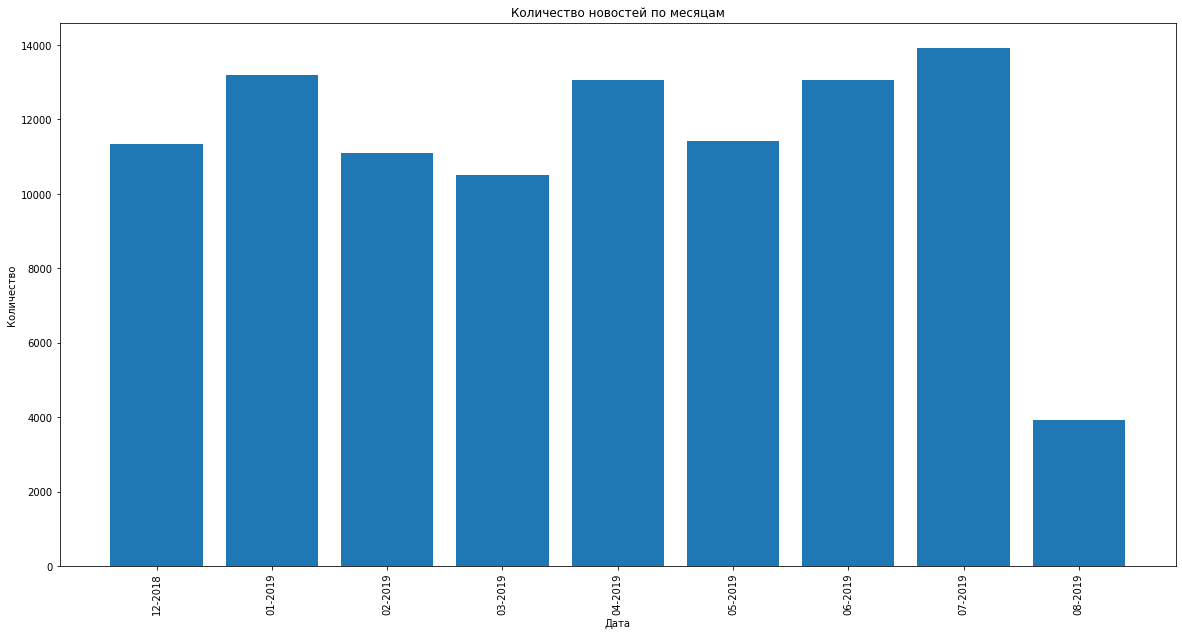

In [32]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
ax.set_title('Количество новостей по месяцам')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
plt.show()

### Создание словаря для анализа

В данной части блокнота будет подготовлен словарь из всего множества слов во всем датасете. Для каждой новости будет выполнена токенизация. Затем будет собран словарь из всех токенов, очистка от знаков препинания, и после данных процедур создается два списка - один без удаления стоп-слов, второй с удалением. Анализ проводится по частоте вхождений для каждого списка

In [33]:
def create_dictionary(text):
    for news in text:
        tokens = list(tokenize(news.lower()))
        yield([_.text for _ in tokens])

In [34]:
data_ria.text = list(create_dictionary(data_ria.text.values))

In [35]:
# Соберем словарь из новостей для последующего анализа, без объединения повторяющихся слов
dictionary = list(itertools.chain.from_iterable(data_ria.text.values))

In [ ]:
# Соберем значки препинания, часть возьмем из готовой библиотеки, часть добавим свои

In [47]:
punctuation = list(punctuation)

In [48]:
punctuation += ['«','»','—','n','»,','».','–', '...']

In [38]:
garbage_words = ['nранее', 'nв', 'nпо', 'nтакже','u','n—']

In [49]:
# Словарь без удаления стопслов
dictionary_with_stopwords = [item for item in dictionary if item not in punctuation]

In [50]:
dictionary_with_stopwords = [item for item in dictionary_with_stopwords if item not in garbage_words]

In [51]:
stopwords_01 = open('../nlp/preprocessing/stopwords.txt', 'r', encoding='UTF-8')
stopwords_01 = stopwords_01.read().split('\n')
stopwords_02 = open('../nlp/preprocessing/stopwords_02.txt', 'r', encoding='UTF-8')
stopwords_02 = stopwords_02.read().split('\n')

In [52]:
stopwords = stopwords_01 + stopwords_02

In [53]:
# Словарь после удаления стопслов
dictionary_without_stopwords = [item for item in dictionary_with_stopwords if item not in stopwords]

### Аналитика по словам

#### 20 самых популярных слов без удаления стопслов

In [54]:
Counter(dictionary_with_stopwords).most_common(20)

[('в', 886599),
 ('и', 432068),
 ('на', 330430),
 ('по', 223267),
 ('что', 222411),
 ('с', 197283),
 ('не', 142561),
 ('новости', 138773),
 ('риа', 138140),
 ('о', 90305),
 ('из', 83483),
 ('для', 70011),
 ('к', 69934),
 ('за', 61852),
 ('его', 61708),
 ('он', 61182),
 ('как', 60998),
 ('москва', 60260),
 ('года', 58512),
 ('а', 57218)]

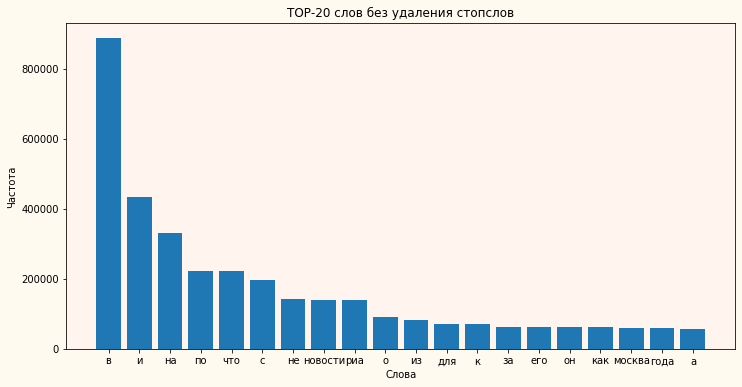

In [55]:
x = dict(Counter(dictionary_with_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_with_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

#### 20 самых популярных слов после удаления стопслов 

In [56]:
Counter(dictionary_without_stopwords).most_common(20)

[('новости', 138773),
 ('риа', 138140),
 ('россии', 51595),
 ('сша', 48017),
 ('рф', 47674),
 ('заявил', 43589),
 ('украины', 28291),
 ('словам', 28245),
 ('сообщил', 26338),
 ('данным', 26010),
 ('президента', 24758),
 ('говорится', 21793),
 ('области', 21354),
 ('страны', 20600),
 ('глава', 20193),
 ('мая', 19613),
 ('отметил', 18068),
 ('сообщает', 17013),
 ('рублей', 16235),
 ('из-за', 16172)]

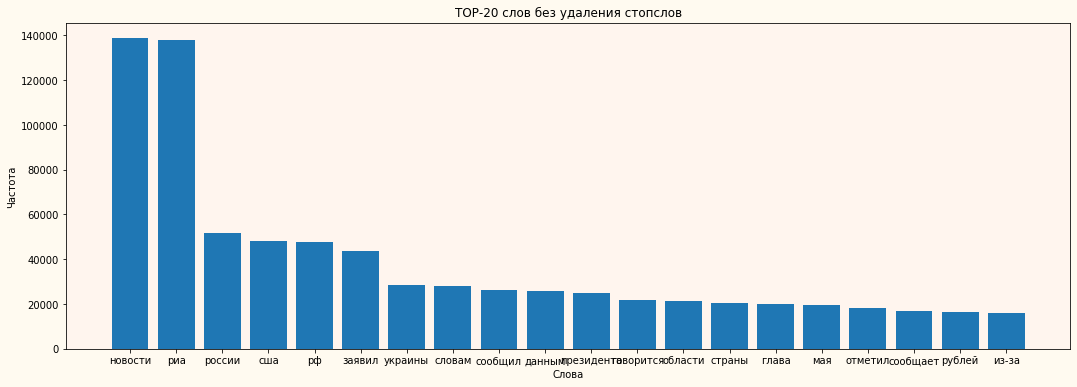

In [57]:
x = dict(Counter(dictionary_without_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_without_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

### Рубрики Ria

In [58]:
# Считаем количество рубрик в датасете Ria, а также выведем значения
print('Количество рубрик = ', data_ria.topics.unique().shape)
data_ria['topics'].unique()

Количество рубрик =  (1120,)


array(['Происшествия', 'В мире', 'Экономика', ...,
       'ЧП на военном складе в Красноярском крае', 'Лиссабон (город)',
       'The Guardian'], dtype=object)

In [60]:
data_ria.groupby('topics')['topics'].count().head()

topics
2 февраля - день сурка    1
BAFTA                     1
BBC                       8
Cirque du Soleil          1
Comedy Club Production    1
Name: topics, dtype: int64

Тут надо разбираться, все ли рубрики нам нужны